# Mining used-car sales

This is a running log of some work on used-car saled. I have no intention to use this information for financial purposes, rather I'd like to ask the question "is there regional variation in used-car prices?". To do this I will use the `BeautifulSoup` package to look at [www.pistonheads.com](www.pistonheads.com), my preferred way to search for used cars.

In [2]:
from BeautifulSoup import BeautifulSoup 
import urllib
import pandas as pd
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
%matplotlib inline

import seaborn as sns
sns.set_style(rc={'font.family': ['sans-serif'],'axis.labelsize': 25})
sns.set_context("notebook")

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.labelsize'] = 18

After some fiddling I have wrapped up the method to get a page of results (100 at a time) in a function:

In [3]:
def strip_results_from_ad(ad):
    """ Strip out the information from a single advert and add it to the results dictionary"""
    
    desc = ad.find("div", attrs={"class": "listing-headline"}).find("h3").text
    loc = ad.findAll("p", attrs={"class": "location"})[0].text
    price = int(ad.find("div", attrs={"class": "price"}).text.replace(u"&#163;", "").replace(",", ""))   

    specs = ad.find("ul", attrs={"class": "specs"}).findAll("li")
    if len(specs) == 4:
        miles = int(specs[0].text.rstrip(" miles").replace(",", ""))
        fuel = specs[1].text
        bhp = int(specs[2].text.rstrip(" bhp"))
        transmission = specs[3].text
    else:
        fuel = "NA"
        bhp = np.nan
        transmission = "NA"   
        try:
            miles = int(specs[0].text.rstrip(" miles").replace(",", ""))
        except:
            # Except any error...!
            miles = np.nan
            
    return desc, loc, price, miles, fuel, bhp, transmission

def create_url(page=1, M=269, rpp=100):
    base = ("http://www.pistonheads.com/classifieds?Category=used-cars"
            "&M={M}&ResultsPerPage={rpp}&Page={page}")
    return base.format(page=page, rpp=rpp, M=M)

def get_results(*args, **kwargs):
    url = create_url(*args, **kwargs)
    f = urllib.urlopen(url).read()    
    soup = BeautifulSoup(f)
    ads = soup.findAll("div", attrs={"class": "ad-listing"})

    results = {"desc":[], "loc":[], "price":[], "miles":[], "fuel":[], "bhp":[], "transmission":[]}
    for ad in ads:
        try:
            desc, loc, price, miles, fuel, bhp, transmission = strip_results_from_ad(ad)
        except:
            break
    
        results["desc"].append(desc)
        results["loc"].append(loc)
        results["price"].append(price)   
        results["miles"].append(miles)
        results["fuel"].append(fuel)
        results["bhp"].append(bhp)
        results["transmission"].append(transmission)

    return results

### An example

Here we get 100 results from the url with "M" 269. On the pistonheads website this corresponds to a BMW 1 series. I choose this search in particular as there isn't huge variation in the specs, most have a similar engine size and there are few special runs. Let's have a look at the first few results

In [4]:
r = get_results(M=269, rpp=20)
df_small = pd.DataFrame(r)
df_small

,bhp,desc,fuel,loc,miles,price,transmission
0,302,BMW 1 Series 3.0 135i M Sport 2dr (2008),Petrol,Plymouth,43000,14450,Manual
1,141,BMW 1 Series 2.0 118d Sport Plus 2dr (2012),Diesel,Essex,38000,17450,Automatic
2,134,BMW 1 Series 1.6 116i Sport Sports Hatch 5dr (...,Petrol,Essex,11800,14500,Manual
3,141,BMW 1 Series 2.0 118i M Sport 2dr (2011),Petrol,Essex,18023,16495,Automatic
4,141,BMW 1 Series 2.0 118d Sport 5dr (2009),Diesel,Plymouth,67500,8995,Automatic
5,141,BMW 1 Series 2.0 118d SE 2dr (2011),Diesel,Essex,68000,11895,Manual
6,174,BMW 1 SERIES 120D M SPORT ...,Diesel,Warwickshire,62000,8995,Manual
7,141,BMW 1 Series 2.0 118d M Sport 2dr (2011),Diesel,Glamorgan,58343,11995,Manual
8,141,BMW 118d SE Business Sat Nav FSH Stunning (2010),Diesel,South Yorkshire,67197,11900,Automatic
9,134,BMW 116i 2.0 ES (2013),Petrol,West Yorkshire,12361,13990,Manual


This looks good so far, now from the source website we see there is 2,580 entries so let's pull down a few and see what we can do with the data. The best way to do this is to iterate through the page counts and concatanate the resulting data frames:

In [6]:
dfs = []
for page in xrange(1, 25):
    r = get_results(M=269, rpp=100, page=page)
    dfs.append(pd.DataFrame(r))

In [7]:
df = pd.concat(dfs)
len(df)

1721

Okay so now we have a good number of adverts to look at. 

### Mileage VS Price

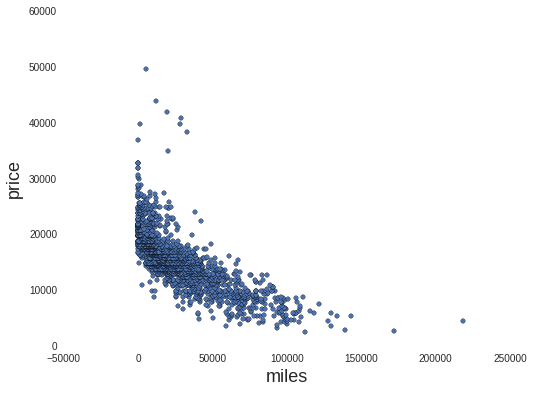

In [8]:
ax = df.sort("price").plot("miles", "price", kind="scatter")

This is kind of messy and I would be interested to know what those low-milage high price outliers indicate

### Outliers

We will use the `pandas` query module (which requires `numexpr` to be installed) to have a look at these outliers.

In [9]:
df.query("miles < 50000 and price > 30000") 

,bhp,desc,fuel,loc,miles,price,transmission
86,NaN,BMW 1M **UK`S FINEST BUYERS** (2011),NA,Nottinghamshire,20000,35000,NA
13,335,BMW 1M COUPE // SOLD // SIMILAR REQUIRED (2011),Petrol,Surrey,27930,39995,Manual
15,NaN,BMW 1 SERIES M135i 5dr Step Auto (2015),NA,Derbyshire,101,30490,NA
30,NaN,1 SERIES DIESEL HATCHBACK 120d xDrive M Sport ...,NA,West Midlands,10,30850,NA
65,NaN,BMW 1M WANTED (2011 – 2012) (2011),NA,Staffordshire,1000,40000,NA
47,335,2011/61 BMW 1M COUPE - ORANGE - SAT NAV - 32K ...,Petrol,Deeside,32900,38495,Manual
18,335,BMW 1 Series M (2011),Petrol,Oxfordshire,19500,41995,Manual
38,335,BMW 1M 2...,Petrol,Grampian,29000,41000,Manual
3,335,1 SERIES COUPE M 2dr (2011),Petrol,Nottinghamshire,5434,49850,Manual
98,NaN,BMW 1 SERIES 125d M Sport 5dr Step Auto [Nav] ...,NA,Derbyshire,156,32990,NA


As we can see these are all the "1M" series, a much faster version. The BHP is 335 which is significantly greater than the average:

In [10]:
df.bhp.mean()

151.00447284345049

### Averaged Price VS Mileage

Let's clean the data by removing all `NaN` (this is typically ill-advised, but this is just for fun) and also get rid of those high-performance cars

In [11]:
df_clean = df[~np.isnan(df.price)]
df_clean = df_clean[~np.isnan(df_clean.miles)]
df_clean = df_clean[df_clean.price < 30000]
df_clean = df_clean.sort("miles")

And now we have a clean collection, we will apply a rolling mean to the price and milage:

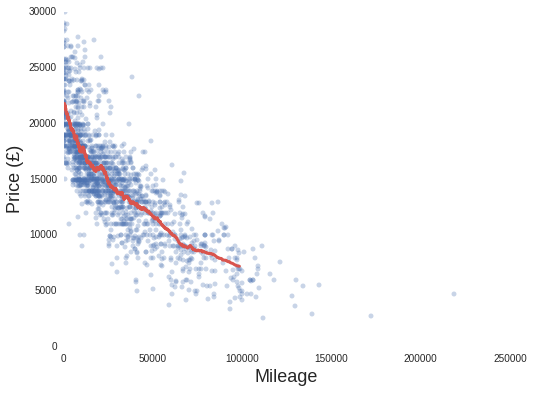

In [12]:
ax = plt.subplot(111)
window = 100

mean_miles = pd.rolling_mean(df_clean.miles, window, center=True)
mean_price = pd.rolling_mean(df_clean.price, window, center=True)

# Drop the nans created in the rolling_window
mean_miles = mean_miles[~np.isnan(mean_miles)]
mean_price = mean_price[~np.isnan(mean_price)]

ax.plot(df_clean.miles, df_clean.price, "o", alpha=0.3, markersize=5)
ax.plot(mean_miles, mean_price, lw=3, color=seaborn.xkcd_rgb["pale red"])
ax.set_xlabel("Mileage")
ax.set_ylabel(u"Price (£)")

plt.show()

### Fitting to the data

We may now imagine coming up with a model for the price. The obvious answer is to begin by stating that the depreciation is proportional to the mileage, therefore:

$$ \frac{dP}{dm} = -k P $$

where $P$ is the price, $m$ is the mileage and $k$ is a constant of proportionality. Solving in the usual way yields:

$$ P(m) = P_{0} e^{-km} $$

Let's try fitting this:

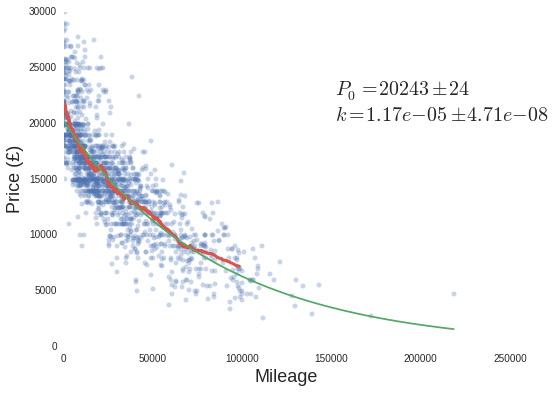

In [13]:
import scipy.optimize as so
ax = plt.subplot(111)

def P(m, P0, k):
    return P0 * np.exp(-k * m)

popt, pcov = so.curve_fit(P, mean_miles, mean_price, p0=[20000, 1e-10])



ax.plot(df_clean.miles, df_clean.price, "o", alpha=0.3, markersize=5)
ax.plot(mean_miles, mean_price, lw=3, color=seaborn.xkcd_rgb["pale red"])

fit_miles = np.linspace(df_clean.miles.min(), df_clean.miles.max(), 1000)
ax.plot(fit_miles, P(fit_miles, *popt), zorder=10)
ax.annotate(xy=(0.6, 0.7), xycoords="figure fraction", 
            s=("$P_0={:5.0f} \pm {:5.0f}$\n$k={:1.2e} \pm {:1.2e}$".format(
               popt[0], np.sqrt(pcov[0, 0]), popt[1], np.sqrt(pcov[1, 1]))), 
            fontsize=20)

ax.set_xlabel("Mileage")
ax.set_ylabel(u"Price (£)")

plt.show()

This model seems fairly able to predict the average used car sale price. The parameter $P_0$ measures the value at 0 miles, of course all used-cars should have at least some mileage to qualify as used, but a surprising number have very low mileage:

In [14]:
len(df.query("miles < 500"))

77

### Add latitude and longitude of the location

In [40]:
df['P0'] = df.price*np.exp(popt[1] * df.miles)
df.head()

,bhp,desc,fuel,loc,miles,price,transmission,ppm,P0
0,302,BMW 1 Series 3.0 135i M Sport 2dr (2008),Petrol,Plymouth,43000,14450,Manual,0.336047,23852.142631
1,141,BMW 1 Series 2.0 118d Sport Plus 2dr (2012),Diesel,Essex,38000,17450,Automatic,0.459211,27173.509499
2,134,BMW 1 Series 1.6 116i Sport Sports Hatch 5dr (...,Petrol,Essex,11800,14500,Manual,1.228814,16637.874053
3,141,BMW 1 Series 2.0 118i M Sport 2dr (2011),Petrol,Essex,18023,16495,Automatic,0.915219,20350.826075
4,141,BMW 1 Series 2.0 118d Sport 5dr (2009),Diesel,Plymouth,67500,8995,Automatic,0.133259,19754.954949


In [125]:
grouped = df.groupby(['loc',])

In [124]:
P0_mean = grouped['P0'].mean().values
counts = grouped['P0'].count().values
locs = grouped.all().index

df_mean = pd.DataFrame(dict(locs = locs,
                            P0_mean = P0_mean,
                            counts = counts))
df_mean.head()

,P0_mean,counts,locs
0,20971.479830,1,Aberdeen
1,20317.160697,13,Aberdeenshire
2,19165.648924,8,Angmering
3,16588.706978,11,Antrim
4,26461.512739,1,Armadale


In [127]:
df_mean_clean = df_mean[df_mean.counts > 1]
df_mean_clean.head()

,P0_mean,counts,locs
1,20317.160697,13,Aberdeenshire
2,19165.648924,8,Angmering
3,16588.706978,11,Antrim
8,19545.821559,7,Ayr
9,22521.949675,32,Bedfordshire


In [128]:
from geopy.geocoders import Nominatim
N = Nominatim()
location = [N.geocode(loc) for loc in df_mean_clean.locs]
df_mean_clean['location'] = location

/home/greg/Programs/ipython/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [141]:
df_mean_clean = df_mean_clean.dropna()

In [147]:
df_mean_clean['lat'] = [l.latitude for l in df_mean_clean.location.values]
df_mean_clean['lon'] = [l.longitude for l in df_mean_clean.location.values]

/home/greg/Programs/ipython/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/greg/Programs/ipython/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [149]:
df_mean_clean.head()

,P0_mean,counts,locs,location,lat,lon
1,20317.160697,13,Aberdeenshire,"(Aberdeenshire, Scotland, United Kingdom, (57....",57.166667,-2.666667
2,19165.648924,8,Angmering,"(Angmering, West Sussex, South East, England, ...",50.828350,-0.484014
3,16588.706978,11,Antrim,"(Antrim, County Antrim, Northern Ireland, Unit...",54.715139,-6.219204
8,19545.821559,7,Ayr,"(Ayr, South Ayrshire, Scotland, United Kingdom...",55.459412,-4.632670
9,22521.949675,32,Bedfordshire,"(Bedfordshire, United Kingdom, (52.0640034, -0...",52.064003,-0.411114


As a result we have predicted the initial price to be $20259 \pm 23$ which isn't all that far off the actual new-car prices $21180-21710$.

TypeError: 'numpy.ndarray' object is not callable

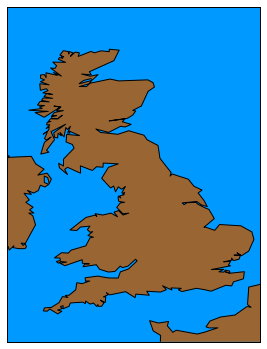

In [153]:
fig = plt.figure()
from mpl_toolkits.basemap import Basemap

# Calculate some parameters which will be resused]
#lat_0 = df.latitude.mean()
#lon_0 = df.longitude.mean()
#llcrnrlon, urcrnrlon = PaddingFunction(df.longitude.min(), df.longitude.max(), frac=0.3)
#llcrnrlat, urcrnrlat = PaddingFunction(df.latitude.min(), df.latitude.max())

lat_0 = 0
lon_0 = 1
llcrnrlon, urcrnrlon = -7, 2
llcrnrlat, urcrnrlat = 49, 60

# Create a map, using the Gall–Peters projection, 
m = Basemap(projection='gall',  
              resolution = 'l', 
              area_thresh = 10000.0,
              lat_0=lat_0, lon_0=lon_0,
              llcrnrlon=llcrnrlon,
              urcrnrlon=urcrnrlon,
              llcrnrlat=llcrnrlat, 
              urcrnrlat=urcrnrlat,
              ax=fig.gca()
              )
m.drawcounties()
m.drawcoastlines()
m.fillcontinents(color = '#996633')
m.drawmapboundary(fill_color='#0099FF')

lons = df_mean_clean.lon.values
lats = df_mean_clean.lat.values
z = df_mean_clean.P0_mean.values

x, y = m(lons*180./np.pi, lats*180./np.pi)

m.pcolormesh(x, y, z)